In [40]:
from dateutil.relativedelta import relativedelta
from scipy.signal import savgol_filter

In [41]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


# time-related stack
from datetime import datetime as dt

# miscellaneous
import warnings
warnings.filterwarnings("ignore")


EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 08-05-2023
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier
08-15 DATE : Date YYYYMMDD
17-21 TG   : mean temperature in 0.1 &#176;C
23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).
Blended and updated with sources: 111448 127488 128124 
See file sources.txt and stations.txt for more info.

In [43]:
# load data txt file as a dataframe

df = pd.read_csv(
    "./data/TG_STAID002759.txt",
    # data starts from line 20
    skiprows = 19,
    # remove empty space in column name
    skipinitialspace = True,
    # parse DATE column 1
    parse_dates = [1],
)

In [44]:
df.tail()

,SOUID,DATE,TG,Q_TG
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0
53780,111448,2023-03-31,108,0


In [45]:
df_missing = df[df["Q_TG"]==9]

In [46]:
df_missing["DATE"].min()

Timestamp('1945-04-25 00:00:00')

In [47]:
df_missing["DATE"].max()

Timestamp('1945-11-05 00:00:00')

In [48]:
missing_days = (df_missing["DATE"].max()-df_missing["DATE"].min()).days + 1
missing_days

195

In [49]:
missing_days == df_missing.shape[0]

True

In [50]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10



In [51]:
# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: clean_temp(df,x),
    axis=1
)

In [52]:
df.isna().count()

SOUID    53781
DATE     53781
TG       53781
Q_TG     53781
TEMP     53781
dtype: int64

In [53]:
df.shape

(53781, 5)

In [54]:
df.columns=df.columns.str.lower()
clean_df=df.set_index("date")[["temp"]]

In [55]:
clean_df.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [56]:
# Train the data until 2022-12-31. Last 3 monts is the test
train= clean_df[:"2022-12-31"]
test= clean_df["2023-01-01":]

In [57]:
train.shape

(53691, 1)

In [58]:
test.shape

(90, 1)

In [59]:
train.to_csv("train.csv")
test.to_csv("test.csv")

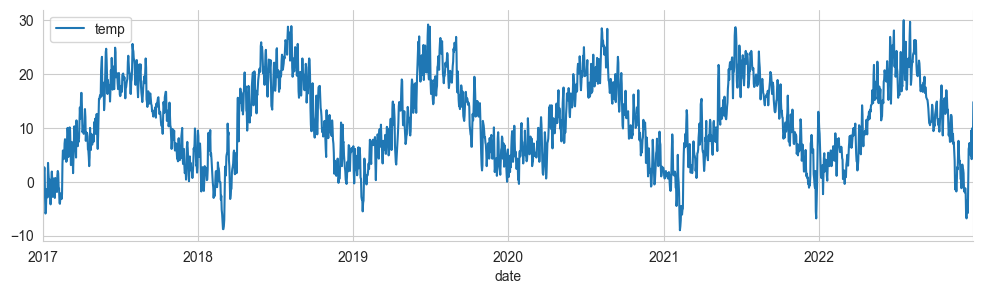

In [60]:
# plot the last 5 years
train_last_five = train["2017-01-01":]


mpl.rc('figure',figsize=(12,3),dpi=100)

train_last_five['temp'].plot(legend=True)
sns.despine()

In [61]:
# savitzky-golary filter will be used to filter the noise
train['denoised'] = savgol_filter(np.array(train['temp']), 99, 3, mode='nearest')
train['noise'] = train['temp'] - train['denoised']


In [62]:
print(train['denoised'])

date
1876-01-01   -0.659391
1876-01-02   -0.772946
1876-01-03   -0.858296
1876-01-04   -1.025494
1876-01-05   -1.151521
                ...   
2022-12-27    6.827954
2022-12-28    7.212065
2022-12-29    7.611574
2022-12-30    8.021626
2022-12-31    8.411407
Name: denoised, Length: 53691, dtype: float64


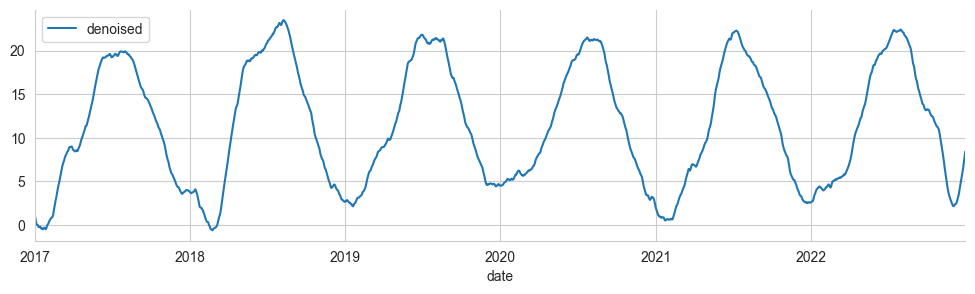

In [63]:
# plot the last 5 years
train_denoised_five = train["2017-01-01":]

mpl.rc('figure',figsize=(12,3), dpi=100)

train_denoised_five['denoised'].plot(legend=True)
sns.despine()



**DENOISED DATA**


In [64]:
train.head()

,temp,denoised,noise
date,,,
1876-01-01,2.2,-0.659391,2.859391
1876-01-02,2.5,-0.772946,3.272946
1876-01-03,0.3,-0.858296,1.158296
1876-01-04,-5.8,-1.025494,-4.774506
1876-01-05,-9.8,-1.151521,-8.648479


In [65]:
train['timestep'] = list(range(train.shape[0]))

**Trend Model**

In [66]:
X_trend_denoised = train[['timestep']]
y_trend_denoised = train['denoised']

In [67]:
X_trend_denoised.shape

(53691, 1)

In [68]:
# trend model for denoised data 
trend_model_de = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [69]:
trend_model_de.fit(X_trend_denoised,y_trend_denoised)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [70]:
train['trend_de'] = trend_model_de.predict(X_trend_denoised)

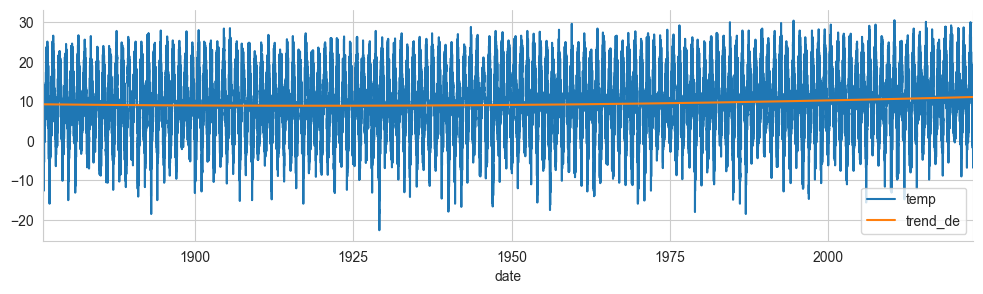

In [71]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['temp','trend_de']].plot(legend=True)
sns.despine()

**Seasonality model**

In [72]:
train['detrended_de'] = train['temp'] - train['trend_de']

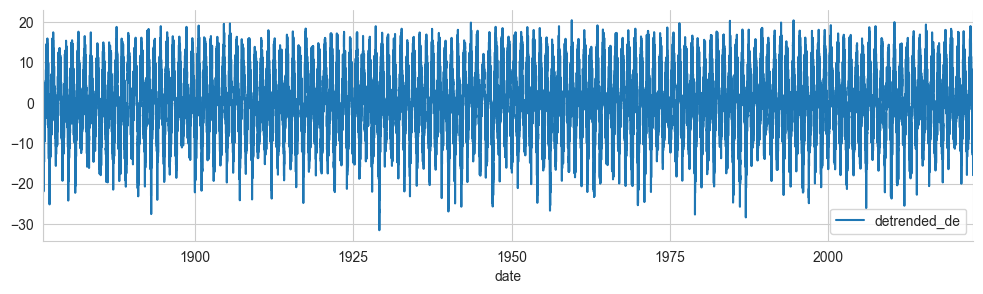

In [73]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended_de'].plot(legend=True)
sns.despine()

In [78]:
train['day'] = train.index.day

In [79]:
X_seasonality_de = train[['day']]
y_seasonality_de = train['detrended_de']

In [80]:
# seasonality model
seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [81]:
seasonality_model.fit(X_seasonality_de, y_seasonality_de)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [82]:
train['seasonality_de'] = seasonality_model.predict(X_seasonality_de)

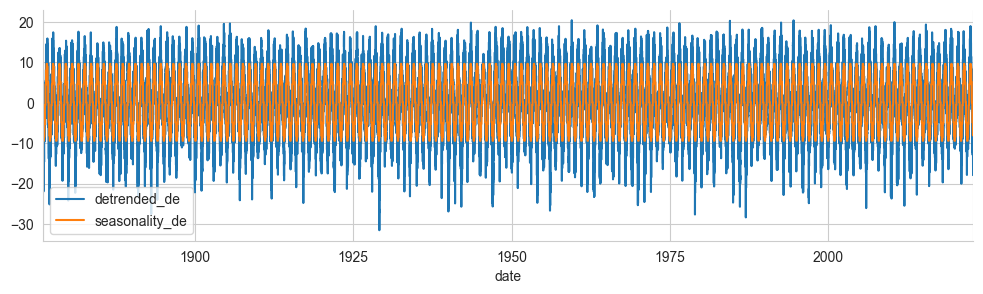

In [83]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended_de','seasonality_de']].plot(legend=True)
sns.despine()

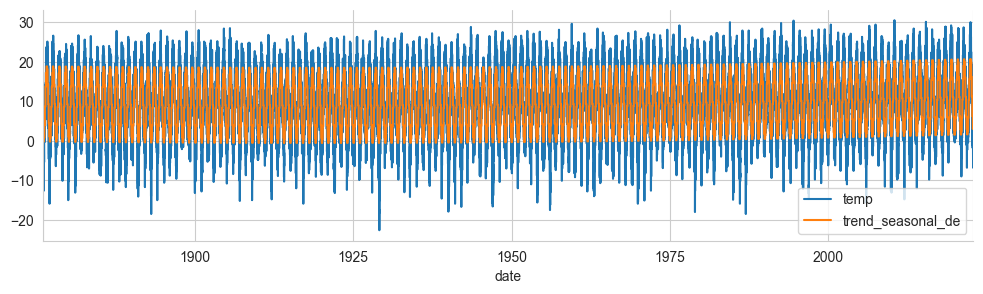

In [84]:
# combine trend and seasonality

train['trend_seasonal_de'] = train['trend_de'] + train['seasonality_de']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['temp','trend_seasonal_de']].plot(legend=True)
sns.despine()

**REMAINDER**

In [85]:
train['remainder'] = train['temp'] - train['trend_seasonal_de']

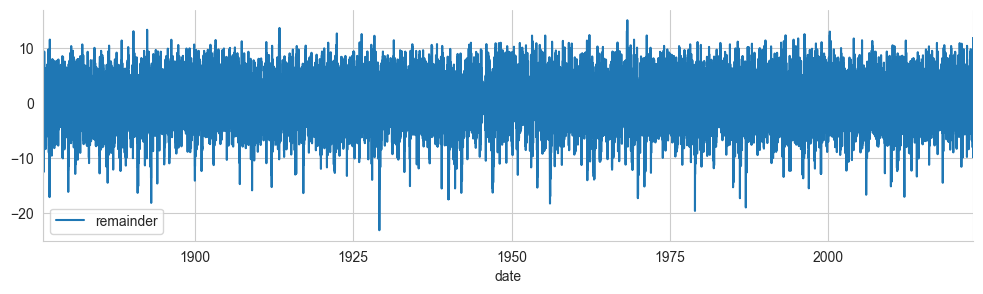

In [86]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

In [87]:
def qcd_variance(series,window=12):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [88]:
# quartile coefficient of dispersion
qcd_variance(train['remainder'])

quartile coefficient of dispersion: 0.461135


In [89]:
temp_remainder = train['remainder'].reset_index()
temp_remainder.to_csv('./data/temp_remainder.csv',index=False)

In [90]:
df = pd.read_csv("./data/temp_remainder.csv").set_index('date')
df.tail()

,remainder
date,
2022-12-27,1.186515
2022-12-28,3.286399
2022-12-29,6.986283
2022-12-30,4.586168
2022-12-31,11.786052


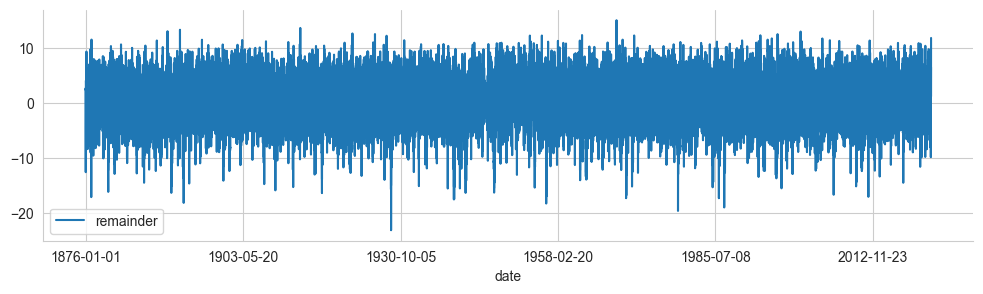

In [91]:
mpl.rc('figure',figsize=(12,3),dpi=100)

df['remainder'].plot(legend=True)
sns.despine()

**Homoscedasticity**

In [92]:
qcd_variance(df['remainder'])

quartile coefficient of dispersion: 0.461135


**Lagged features**

In [93]:
def create_lagged_features(df, number_of_lags):
    """"""
    df = df[['remainder']]
    
    lags = list(range(1, number_of_lags+1))
    
    for lag in lags:
        column_name = 'lag_' + str(lag)
        df[column_name] = df['remainder'].shift(lag)
        
    return df

In [94]:
# maximum number of lags to consider. p is order of the auto reg model.
p = 3

In [95]:
# create lag columns in dataframe
df = create_lagged_features(df, p)

In [96]:
df.head()

,remainder,lag_1,lag_2,lag_3
date,,,,
1876-01-01,2.373388,NaN,NaN,NaN
1876-01-02,2.673435,2.373388,NaN,NaN
1876-01-03,0.473482,2.673435,2.373388,NaN
1876-01-04,-5.626471,0.473482,2.673435,2.373388
1876-01-05,-9.626425,-5.626471,0.473482,2.673435
